# Multivariate Linear Models

In [1]:
import  warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Spurious Association

### 5.1

In [4]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["MedianAgeMarriage_s"] = (d["MedianAgeMarriage"] - d["MedianAgeMarriage"].mean())/d["MedianAgeMarriage"].std()

In [5]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 549.32draws/s] 


### 5.2

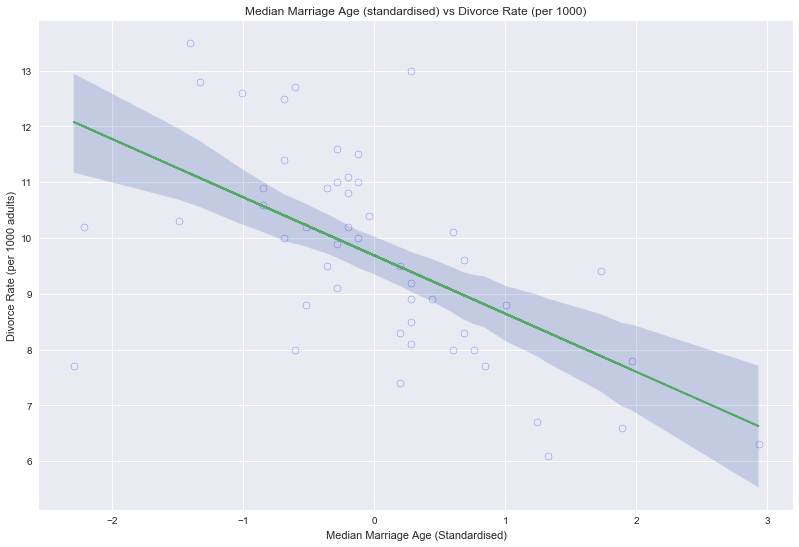

In [6]:
mu_mean = trace_5_1["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["MedianAgeMarriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["MedianAgeMarriage_s"], mu_mean.mean(0))

idx = np.argsort(d["MedianAgeMarriage_s"])
ax.fill_between(d["MedianAgeMarriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Median Marriage Age (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Median Marriage Age (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.3

In [7]:
d["Marriage_s"] = (d["Marriage"] - d["Marriage"].mean())/d["Marriage"].std()

In [8]:
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 999.63draws/s] 


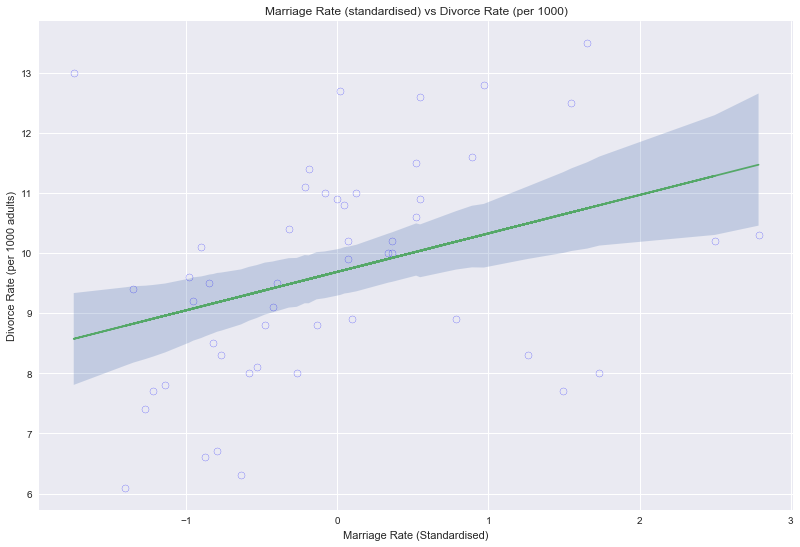

In [9]:
mu_mean = trace_5_2["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["Marriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["Marriage_s"], mu_mean.mean(0))

idx = np.argsort(d["Marriage_s"])
ax.fill_between(d["Marriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Marriage Rate (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Marriage Rate (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.4

In [10]:
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR * d["Marriage_s"] + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 480.28draws/s]


In [11]:
pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.690020,0.207479,0.004472,9.346524,10.013111,1849.101942,1.000128
bR,-0.117827,0.301578,0.007104,-0.569945,0.394374,1673.080401,1.001840
bA,-1.118374,0.304944,0.007409,-1.603705,-0.646235,1502.021048,1.001358
sigma,1.525724,0.160471,0.004142,1.265958,1.760839,1388.772711,1.000687


### 5.5

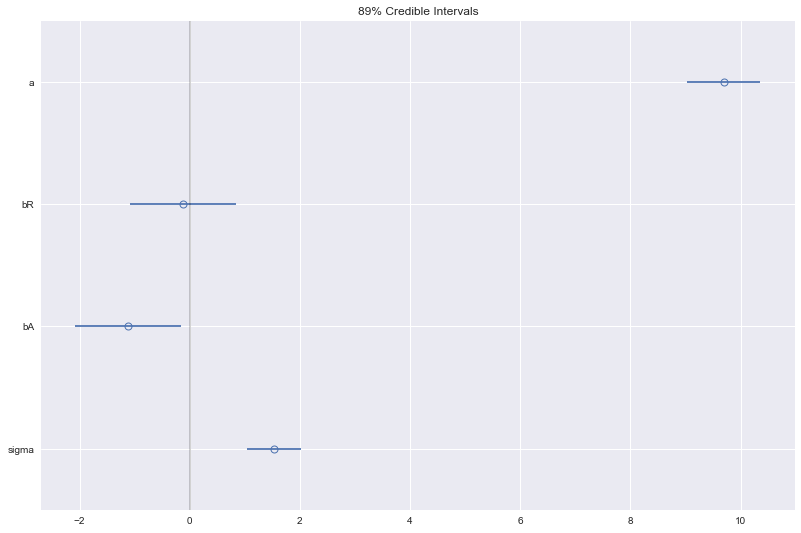

In [12]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.6

In [13]:
with pm.Model() as m5_4:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b = pm.Normal("b", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + b * d["MedianAgeMarriage_s"])
    Marriage_s = pm.Normal("Marriage_s", mu=mu, sd=sigma, observed=d["Marriage_s"])
    trace_5_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 582.62draws/s] 


### 5.7

In [14]:
mu = trace_5_4["mu"].mean(0)
m_resid = d["Marriage_s"] - mu

### 5.8

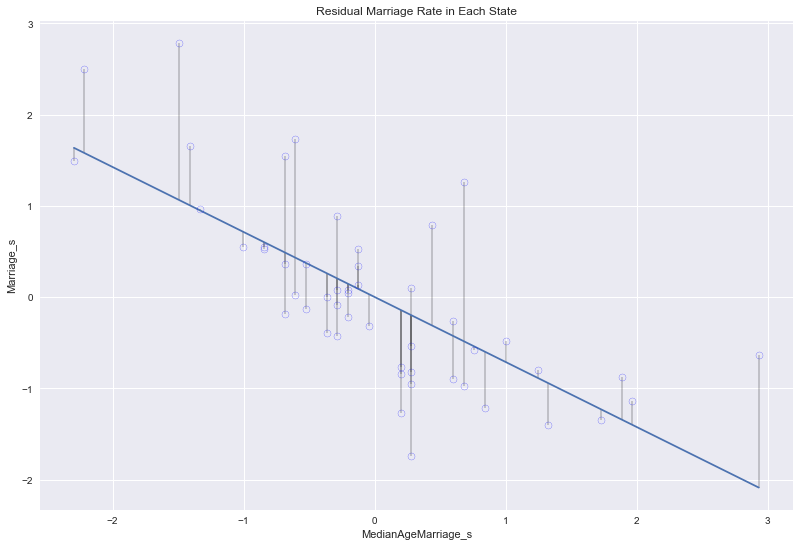

In [15]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
idx = np.argsort(d["MedianAgeMarriage_s"])
ax.plot(d["MedianAgeMarriage_s"][idx], mu[idx])
ax.vlines(d["MedianAgeMarriage_s"], mu, mu + m_resid, alpha=0.2)
ax.plot(d["MedianAgeMarriage_s"], mu + m_resid, "o", mew=0.2, mec="b", mfc="None")
ax.set_title("Residual Marriage Rate in Each State")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Marriage_s");

### 5.9

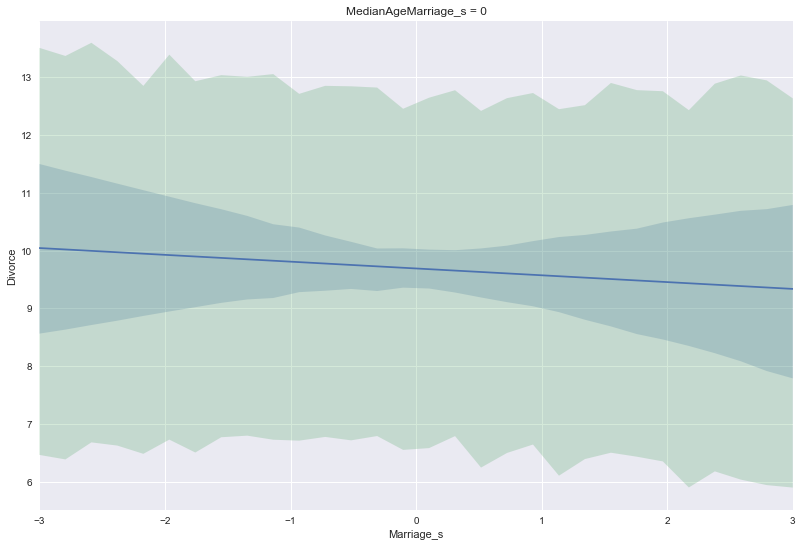

In [16]:
A_avg = d["MedianAgeMarriage_s"].mean()
R_seq = np.linspace(-3, 3, 30)

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"] * A_avg).reshape(-1, 1) +\
     (trace_5_3["bR"].reshape(-1, 1) * R_seq)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

R_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
R_pi = pm.hpd(R_sim)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(R_seq, mu_mean)
ax.fill_between(R_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(R_seq, R_pi[:,0], R_pi[:,1], alpha=0.25)
ax.set_title("MedianAgeMarriage_s = 0")
ax.set_xlabel("Marriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.10

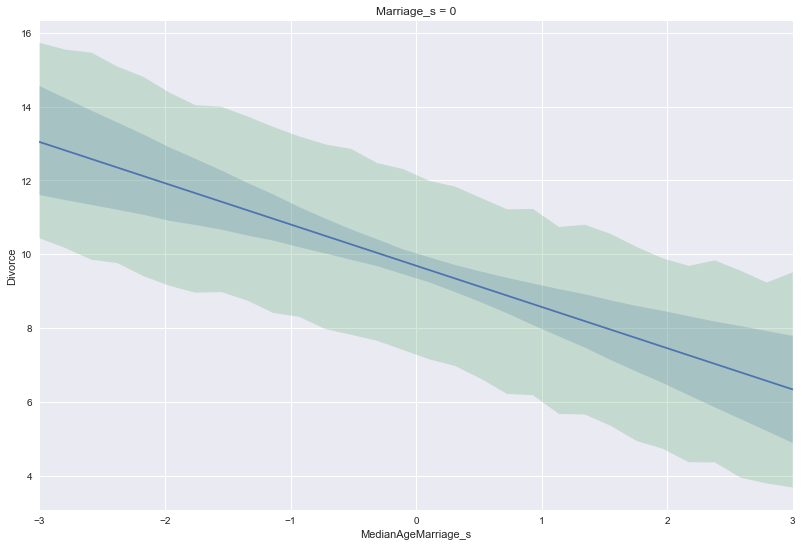

In [17]:
A_seq = np.linspace(-3, 3, 30)
R_avg = d["Marriage_s"].mean()

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"].reshape(-1, 1) * A_seq) +\
     (trace_5_3["bR"] * R_avg).reshape(-1, 1)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

A_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
A_pi = pm.hpd(A_sim, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(A_seq, A_pi[:,0], A_pi[:,1], alpha=0.25)
ax.set_title("Marriage_s = 0")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.11

In [18]:
mu = trace_5_3["mu"]

mu_mean = mu.mean(0).reshape(-1, 1)
mu_pi = pm.hpd(mu, alpha=.11)

divorce_sim = pm.sample_ppc(trace_5_3, samples=1000, model=m5_3)['Divorce']
divorce_mean = divorce_sim.mean(0).reshape(-1, 1)
divorce_pi = pm.hpd(divorce_sim, alpha=.11)

100%|██████████| 1000/1000 [00:02<00:00, 468.69it/s]


### 5.12 - 5.13

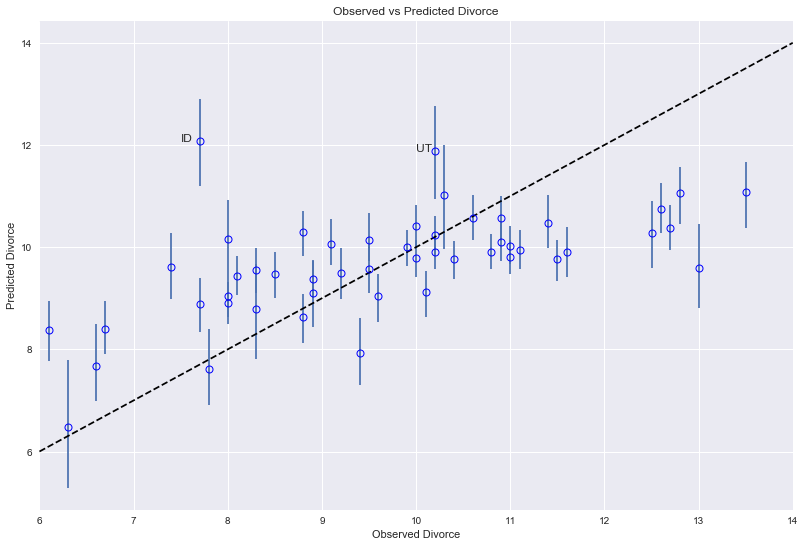

In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["Divorce"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([6, 14], [6, 14], "k--")
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim(6, 14)

ID = (d.loc[12]["Divorce"], mu_mean[12])
UT = (d.loc[43]["Divorce"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.2, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.2, UT[1]));

### 5.14

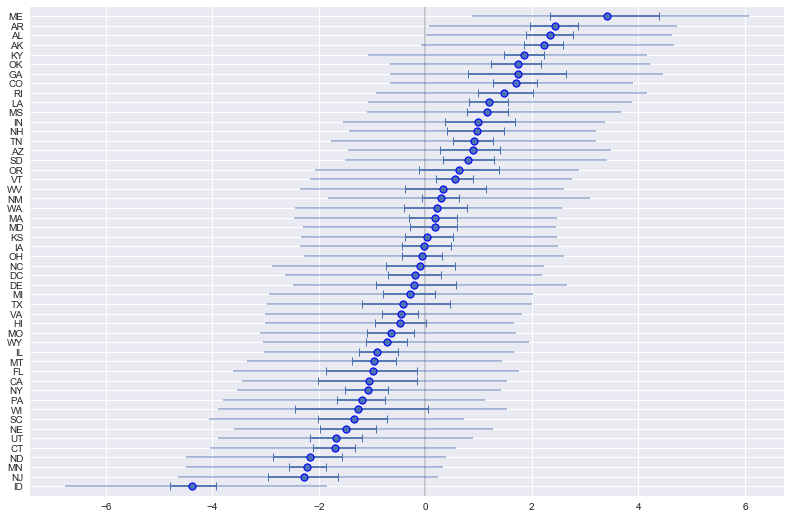

In [20]:
divorce_resid = d["Divorce"] - mu_mean.ravel()
o = np.argsort(divorce_resid)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.vlines(0, -1, len(d), alpha=0.2)
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-divorce_pi).T,
            fmt="o", mfc="C0", mew=1.0, mec="b", alpha=0.5, ecolor="C0")    
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-mu_pi).T, 
            fmt="o", capsize=4, mfc="C0", mew=1.0, mec="b", ecolor="C0")
ax.set_ylim(-1, len(d));

### 5.15

In [21]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

## Masked Relationship

### 5.16

In [22]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.17

In [23]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * d["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

### 5.18

In [24]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.19

In [25]:
dcc = d.dropna()

### 5.20

In [26]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:20<00:00, 195.37draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


### 5.21

In [27]:
pm.summary(trace_5_5, varnames=["a", "bn", "sigma"], alpha=0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.352,0.531,0.021,-0.478,1.183,634.128,1.001
bn,0.005,0.008,0.000,-0.008,0.017,642.013,1.002
sigma,0.193,0.037,0.001,0.141,0.246,664.222,1.000


### 5.22

In [28]:
trace_5_5["bn"].mean() * (76 - 55)

0.09495016595920253

### 5.23

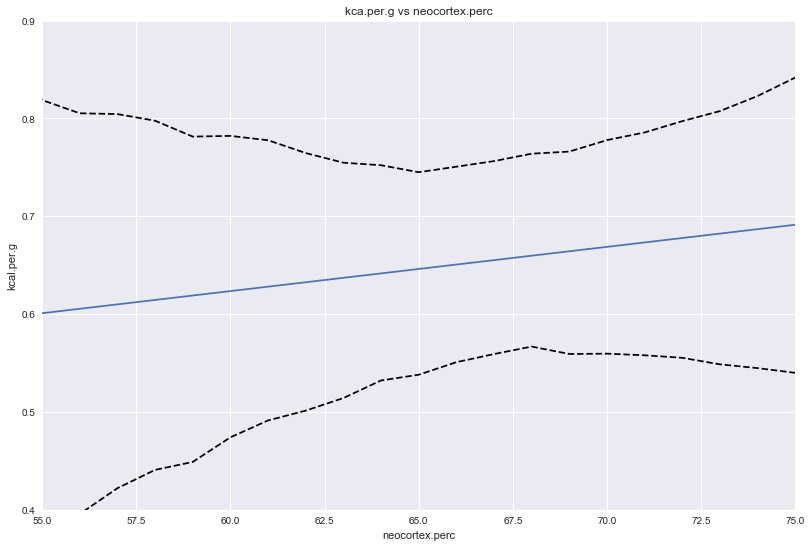

In [29]:
np_seq = np.arange(0, 100)

mu = trace_5_5["a"].reshape(-1, 1) +\
     (trace_5_5["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc")
ax.set_ylim(0.4, 0.9);

### 5.24

In [30]:
dcc["log_mass"] = np.log(dcc["mass"])

### 5.25

In [31]:
with pm.Model() as m5_6:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm * dcc["log_mass"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_6, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 721.81draws/s] 
The acceptance probability does not match the target. It is 0.8790914830071141, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.706813,0.057531,0.001987,0.618906,0.801727,748.096651,1.000668
bm,-0.032488,0.024224,0.000744,-0.070966,0.006108,935.958229,0.999591
sigma,0.184280,0.037601,0.001422,0.127268,0.237505,684.537307,0.999796


### 5.26

In [32]:
with pm.Model() as m5_7:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm*dcc["log_mass"] + bn*dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_7, varnames=["a", "bm", "bn", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:24<00:00, 162.19draws/s]
The acceptance probability does not match the target. It is 0.8849103275901338, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.096108,0.614043,0.027736,-1.960494,-0.100828,409.441655,0.999650
bm,-0.097023,0.028785,0.001257,-0.142087,-0.052550,515.441896,0.999558
bn,0.028107,0.009574,0.000435,0.013562,0.042691,408.803888,0.999591
sigma,0.139225,0.029370,0.001134,0.094762,0.179807,607.662072,0.999967


### 5.27

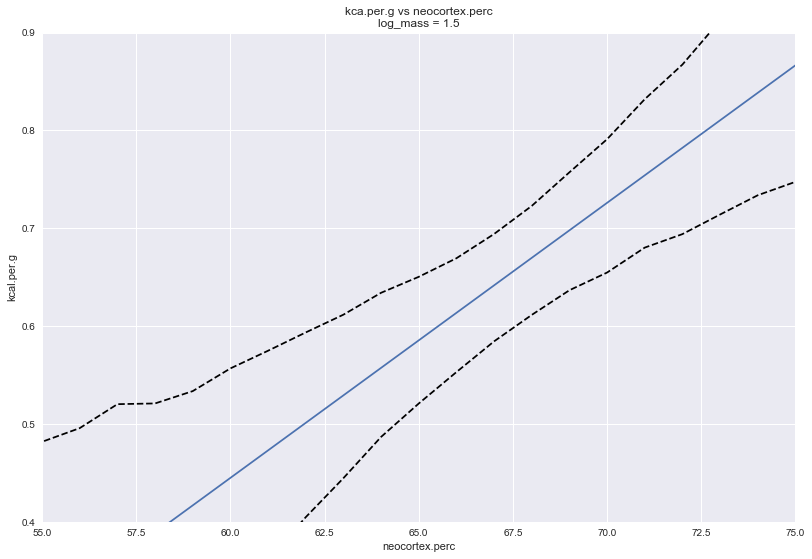

In [33]:
mean_log_mass = dcc["log_mass"].mean()
np_seq = np.arange(0, 100)

mu = trace_5_7["a"].reshape(-1, 1) +\
     (trace_5_7["bm"] * mean_log_mass).reshape(-1, 1) +\
     (trace_5_7["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc\nlog_mass = 1.5")
ax.set_ylim(0.4, 0.9);

### 5.28

In [34]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(loc=rho*x_pos, scale=np.sqrt(1-rho**2))
y = stats.norm.rvs(loc=x_pos-x_neg)
d = pd.DataFrame({"y": y,
                  "x_pos": x_pos,
                  "x_neg": x_neg})

## When adding variables hurts

### 5.29

In [35]:
N = 100
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height,
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 5.30

In [36]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    br = pm.Normal("br", mu=2, sd=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"] + br*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, br, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:45<00:00,  9.20draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,6.698307,0.534183,0.016869,5.841572,7.555353,879.719536,1.004434
bl,5.036359,3.997789,0.153056,-1.099923,11.214339,640.156049,0.999583
br,-4.537682,3.999071,0.152884,-10.702994,1.653302,638.637090,0.999560
sigma,1.370010,0.103120,0.003205,1.203777,1.531675,911.230802,1.000830


### 5.31

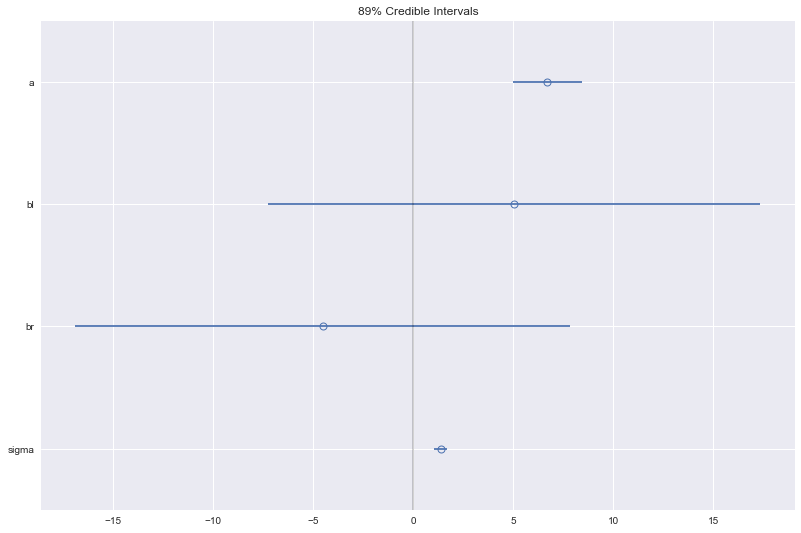

In [37]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.32

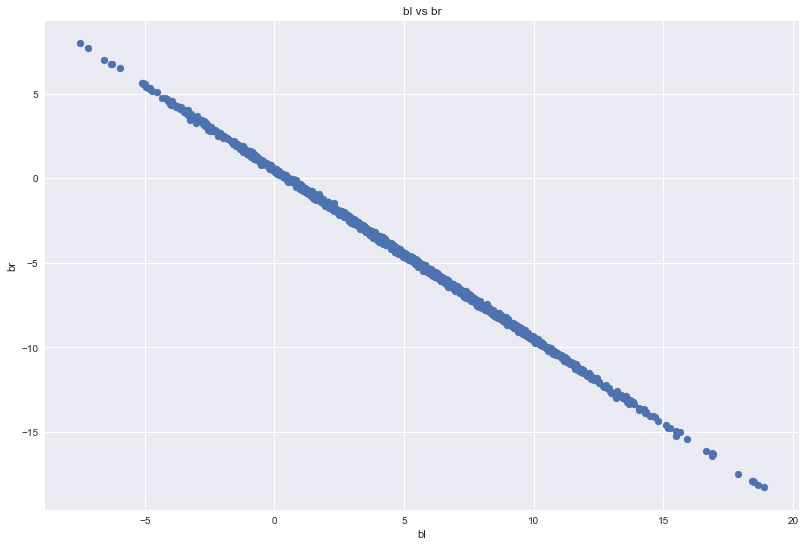

In [38]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.scatter(trace_5_8["bl"], trace_5_8["br"])
ax.set_xlabel("bl")
ax.set_ylabel("br")
ax.set_title("bl vs br");

### 5.33

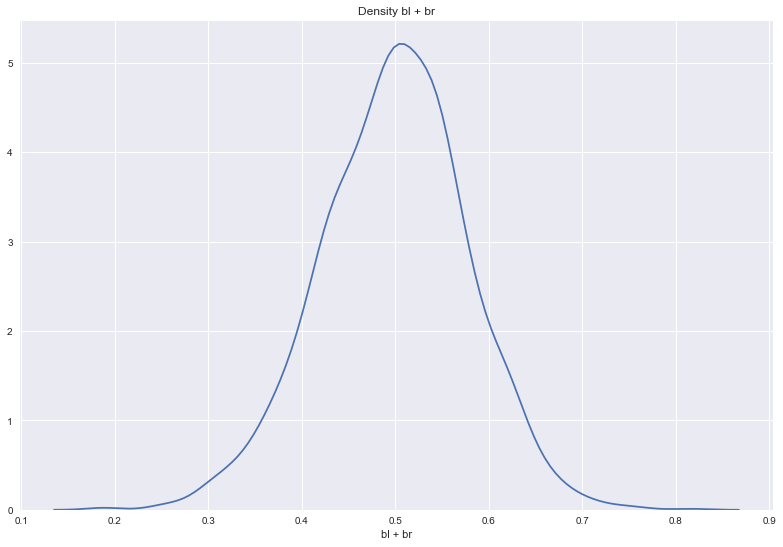

In [39]:
sum_blbr = trace_5_8["bl"] + trace_5_8["br"]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(sum_blbr, ax=ax)
ax.set_title("Density bl + br")
ax.set_xlabel("bl + br");

### 5.34

In [40]:
with pm.Model() as m5_9:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_9 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_9, varnames=["a", "bl", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 517.46draws/s]
The acceptance probability does not match the target. It is 0.8893833393641397, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,6.690912,0.529615,0.015813,5.897196,7.582823,853.262852,0.99950
bl,0.498916,0.078875,0.002355,0.378327,0.628697,859.481375,0.99950
sigma,1.374869,0.100463,0.003467,1.209567,1.522096,870.461828,1.00036


### 5.35

In [41]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.36

In [42]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m5_10:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_10 = pm.sample(draws=1000, tune=1000)

# kcal.per.g regressed on perc.lactose
with pm.Model() as m5_11:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_11 = pm.sample(draws=1000, tune=1000)
    
print(pm.summary(trace_5_10, varnames=["a", "bf", "sigma"], alpha=0.11).round(3))
print(pm.summary(trace_5_11, varnames=["a", "bl", "sigma"], alpha=0.11).round(3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 527.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 380.11draws/s]
The acceptance probability does not match the target. It is 0.8796487626636904, but should be close to 0.8. Try to increase the number of tuning steps.


        mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      0.299  0.044     0.002    0.238     0.371  598.370  1.003
bf     0.010  0.001     0.000    0.008     0.012  668.225  1.004
sigma  0.080  0.012     0.000    0.062     0.097  923.462  1.000
        mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      1.166  0.047     0.002    1.090     1.237  763.847  1.000
bl    -0.011  0.001     0.000   -0.012    -0.009  757.837  1.000
sigma  0.067  0.011     0.000    0.051     0.082  804.915  1.001


### 5.37

In [43]:
with pm.Model() as m5_12:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"] + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_12 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_12, varnames=["a", "bf", "bl", "sigma"], alpha=0.11).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:22<00:00, 179.35draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.011,0.222,0.009,0.652,1.345,565.467,1.002
bf,0.002,0.003,0.000,-0.002,0.006,575.639,1.001
bl,-0.009,0.003,0.000,-0.013,-0.004,574.010,1.002
sigma,0.067,0.009,0.000,0.052,0.082,810.999,1.001


### 5.38

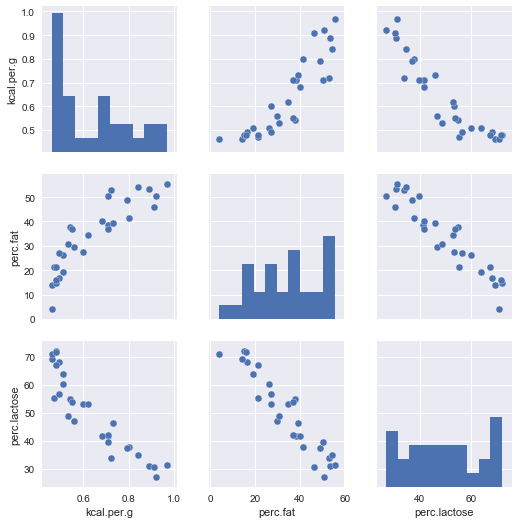

In [44]:
data = d[["kcal.per.g", "perc.fat", "perc.lactose"]]
sns.pairplot(data);

### 5.39

In [45]:
d.corr()["perc.fat"]["perc.lactose"]

-0.9416373456839282

### 5.40

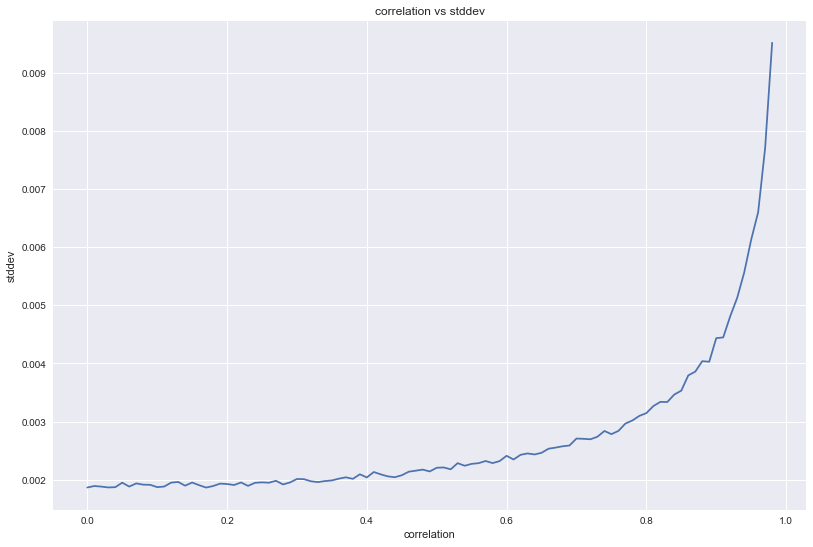

In [46]:
d = pd.read_csv('Data/milk.csv', sep=';')

def sim_coll(r=0.9):
    d['x'] = stats.norm.rvs(size=len(d), 
                            loc = r * d['perc.fat'],
                            scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    m = smf.OLS(d['kcal.per.g'], d[["perc.fat", "x"]]).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def rep_sim_coll(r=0.9, n=100):
    stddev = [sim_coll(r) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 0.99, 0.01)
stddev = [rep_sim_coll(r=z, n=100) for z in r_seq]


f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(r_seq, stddev)
ax.set_title("correlation vs stddev")
ax.set_xlabel("correlation")
ax.set_ylabel("stddev");

### 5.41

In [47]:
# Number of Plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = stats.binom.rvs(1, 0.5 - treatment*0.4)
h1 = h0 + stats.norm.rvs(5-3*fungus)

# compose a clean data frame
d = pd.DataFrame({"h0": h0,
                  "h1": h1,
                  "treatment": treatment,
                  "fungus": fungus})

### 5.42

In [48]:
with pm.Model() as m5_13:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"] + bf*d["fungus"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_13 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_13, varnames=["a", "bh", "bt", "bf", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, bf, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:12<00:00, 308.84draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.149630,0.590182,0.019383,3.224926,5.054042,831.780491,1.000120
bh,1.061527,0.056925,0.001799,0.967451,1.147608,859.250142,0.999735
bt,0.089406,0.258730,0.006695,-0.318412,0.500073,1205.344309,1.000174
bf,-2.678589,0.282003,0.007287,-3.094141,-2.199113,1369.060936,0.999504
sigma,1.106864,0.081491,0.002399,0.986515,1.239547,1068.296254,1.000528


### 5.43

In [49]:
with pm.Model() as m5_14:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_14 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_14, varnames=["a", "bh", "bt", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:12<00:00, 310.83draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,2.660714,0.804100,0.024977,1.470578,3.987064,986.614127,0.999705
bh,1.071217,0.078583,0.002475,0.946013,1.195810,985.756579,0.999807
bt,1.253868,0.317230,0.008122,0.786776,1.796847,1521.620153,0.999629
sigma,1.561103,0.117562,0.003236,1.386097,1.761270,1240.427809,0.999770


## Categorical Variables

### 5.44

In [50]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### 5.45

In [51]:
with pm.Model() as m5_15:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    bm = pm.Normal("bm", mu=0, sd=10)
    a = pm.Normal("a", mu=178, sd=100)
    mu = pm.Deterministic("mu", a + bm*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_15, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 641.40draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,134.820960,1.621237,0.049633,132.089462,137.226188,1017.297065,0.999502
bm,7.290310,2.377261,0.074183,3.199194,10.703476,1029.135648,0.999614
sigma,27.454789,0.849794,0.024561,26.201899,28.929035,1362.182237,0.999500


### 5.46

In [52]:
mu_male = trace_5_15["a"] + trace_5_15["bm"]
pm.hpd(mu_male, alpha=0.11)

array([139.48347491, 144.90535774])

### 5.47

In [53]:
with pm.Model() as m5_15b:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    am = pm.Normal("am", mu=178, sd=100)
    af = pm.Normal("af", mu=178, sd=100)
    mu = pm.Deterministic("mu", af*(1-d["male"]) + am*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [af, am, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1505.13draws/s]


### 5.48

In [54]:
d = pd.read_csv('Data/milk.csv', sep=';')
d["clade"].drop_duplicates()

0        Strepsirrhine
5     New World Monkey
14    Old World Monkey
20                 Ape
Name: clade, dtype: object

### 5.49

In [55]:
d["clade_NWM"] = np.where(d["clade"] == "New World Monkey", 1, 0)

### 5.50

In [56]:
d["clade_OWM"] = np.where(d["clade"] == "Old World Monkey", 1, 0)
d["clade_S"] = np.where(d["clade"] == "Strepsirrhine", 1, 0)

### 5.51

In [57]:
with pm.Model() as m5_16:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b_S = pm.Normal("b_S", mu=0, sd=1)
    b_OWM = pm.Normal("b_OWM", mu=0, sd=1)
    b_NWM = pm.Normal("b_NWM", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + b_NWM*d["clade_NWM"] + b_OWM*d["clade_OWM"] + b_S*d["clade_S"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_16 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_16, varnames=["a", "b_NWM", "b_OWM", "b_S", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b_NWM, b_OWM, b_S, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 765.51draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.547537,0.043686,0.001423,0.482398,0.620616,942.065768,1.002497
b_NWM,0.165894,0.060355,0.001794,0.066106,0.259259,1022.848585,1.001464
b_OWM,0.238996,0.067454,0.001956,0.127893,0.345448,1158.989545,1.001546
b_S,-0.041551,0.071019,0.002047,-0.149450,0.076780,1150.912185,1.000877
sigma,0.129446,0.019055,0.000581,0.100780,0.158637,1295.023894,0.999514


### 5.52

In [58]:
mu_ape = trace_5_16["a"]
mu_NWM = trace_5_16["a"] + trace_5_16["b_NWM"]
mu_OWM = trace_5_16["a"] + trace_5_16["b_OWM"]
mu_S = trace_5_16["a"] + trace_5_16["b_S"]

mu = np.stack([mu_ape, mu_NWM, mu_OWM, mu_S]).T
mu_mean = np.mean(mu, axis=0)
mu_std = np.std(mu, axis=0)
mu_hpd = pm.hpd(mu, alpha=0.11)

pd.DataFrame({"mean": mu_mean,
              "std": mu_std,
              "hpd_5.5": mu_hpd[:, 0],
              "hpd_94.5": mu_hpd[:, 1]},
             index=["mu_ape", "mu_NWM", "mu_OWM", "mu_S"])

,mean,std,hpd_5.5,hpd_94.5
mu_ape,0.547537,0.043686,0.482398,0.620616
mu_NWM,0.713432,0.043048,0.645297,0.782299
mu_OWM,0.786534,0.050797,0.702894,0.861659
mu_S,0.505987,0.057176,0.418961,0.600174


### 5.53

In [59]:
diff_NWM_OWM = mu_NWM - mu_OWM
np.percentile(diff_NWM_OWM, [2.5, 50, 97.5])

array([-0.20471084, -0.07206355,  0.0580762 ])

### 5.54

In [60]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

### 5.55

In [61]:
with pm.Model() as m5_16_alt:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    a = pm.Normal("a", mu=0.6, sd=10, shape=len(d["clade_id"].unique()))
    kcal_per_g = pm.Normal("kcal_per_g", mu=a[d["clade_id"].values], sd=sigma, observed=d["kcal.per.g"])
    trace_5_16_alt = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_16_alt, varnames=["a", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1006.48draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.545418,0.044246,0.000838,0.475085,0.612050,2446.423680,0.999600
a__1,0.714186,0.042725,0.000853,0.645191,0.778311,2093.494024,1.000564
a__2,0.787259,0.055106,0.001138,0.692059,0.866964,2065.937156,1.000560
a__3,0.509535,0.059396,0.001288,0.418498,0.607108,2286.377458,0.999632
sigma,0.130311,0.020017,0.000504,0.101905,0.161989,1443.528908,0.999500


### Ordinary Least Squares and `lm`

Code blocks *5.56 - 6.61* are specific to R's `lm` function and aren't that useful in this exercise

### 5.62

In [62]:
cars = pd.read_csv('Data/cars.csv', index_col=0)
pm.GLM.from_formula("dist ~ speed", data=cars)

## Practice

### Easy

#### 5E1.

2. $\mu_i = \alpha + \beta x_i$
4. $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

#### 5E2.

$a_i = \alpha + \beta_l l_i + \beta_p p_i$

#### 5E3.

$t_i = \alpha + \beta_f f_i + \beta_s s_i$

Since `Time to PHD` is positively associated with both variables, both $\beta_f$ and $\beta_s$ should have positive slopes

#### 5E4.

(1), (3) and (5) are inferentially equivalent

### Medium

#### 5M1.

In [63]:
x1 = stats.norm.rvs(0, 10, 100)
x2 = stats.norm.rvs(x1, 1, 100)
y = stats.norm.rvs(x1, 1, 100)

with pm.Model() as m_5m1:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1 + b_x2*x2)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y)
    trace_5m1 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5m1, varnames=["a", "b_x1", "b_x2", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_x2, b_x1, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 219.08draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.023144,0.094252,0.002580,-0.203640,0.158168,1347.115967,0.999617
b_x1,1.334980,0.087426,0.002967,1.173035,1.526367,758.199737,0.999512
b_x2,-0.311304,0.086842,0.002958,-0.487577,-0.137985,750.162608,0.999508
sigma,0.931489,0.043258,0.001030,0.850702,0.998709,1664.333932,0.999558


#### 5M2.

In [64]:
x1 = stats.norm.rvs(0, 10, 100)
x2 = stats.norm.rvs(x1, 1, 100)
y = stats.norm.rvs(x1-x2, 1, 100)


with pm.Model() as m_5m2:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1 + b_x2*x2)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y)
    trace_5m2 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5m2, varnames=["a", "b_x1", "b_x2", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_x2, b_x1, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 254.62draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.077900,0.099041,0.002998,-0.106859,0.284878,1055.441931,0.999697
b_x1,1.005119,0.107395,0.004534,0.815025,1.238198,547.428247,1.001976
b_x2,-1.016586,0.105628,0.004430,-1.227933,-0.809455,553.389344,1.001701
sigma,0.976846,0.020503,0.000497,0.934693,0.999926,1470.771997,0.999601


#### 5M3.

If marriage rate is defined to be the share of the population that has ever been married, then a high divorce rate might _cause_ a high marriage rate by increasing the number of re-marriages that happen between divorcees and non divorcees.

#### 5M4.

In [65]:
divorce = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

In [66]:
# https://www.worldatlas.com/articles/mormon-population-by-state.html
lds = pd.read_csv("Data/lds.tsv", sep="\t", index_col=0, header=0, 
                  names=["rank", "state", "mormon_pop", "state_pop", "mormon_perc"])
lds.head()

,state,mormon_pop,state_pop,mormon_perc
rank,,,,
1,Utah,2065808,3051217,67.70
2,Idaho,444614,1683140,26.42
3,Wyoming,67505,585501,11.53
4,Nevada,182617,2940058,6.21
5,Arizona,423056,6931071,6.10


In [67]:
features = (divorce
            .merge(lds, left_on="Location", right_on="state")
            .assign(mormon_perc_2=lambda df: df["mormon_perc"]**2)
            .assign(Marriage_s=lambda df: (df["Marriage"] - df["Marriage"].mean())/df["Marriage"].std())
            .assign(MedianAgeMarriage_s=lambda df: (df["MedianAgeMarriage"] - df["MedianAgeMarriage"].mean())/df["MedianAgeMarriage"].std())
            .assign(MormonPerc_s=lambda df: (df["mormon_perc"] - df["mormon_perc"].mean())/df["mormon_perc"].std())
            .assign(MormonPerc2_s=lambda df: (df["mormon_perc_2"] - df["mormon_perc_2"].mean())/df["mormon_perc_2"].std()))

with pm.Model() as m_5m4:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    bm = pm.Normal("bm", mu=0, sd=1)
    ba = pm.Normal("ba", mu=0, sd=1)
    bp1 = pm.Normal("bp1", mu=0, sd=1)
    bp2 = pm.Normal("bp2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                bm*features["Marriage_s"] +\
                                ba*features["MedianAgeMarriage_s"] +\
                                bp1*features["MormonPerc_s"] +\
                                bp2*features["MormonPerc2_s"])
    dr = pm.Normal("Divorce", mu=mu, sd=sigma, observed=features["Divorce"])
    trace_5m4 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5m4, varnames=["a", "bm", "ba", "bp1", "bp2", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp2, bp1, ba, bm, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 252.96draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.503254,0.137564,0.003022,9.253752,9.788833,1793.429072,0.999507
bm,0.113388,0.203848,0.004761,-0.269039,0.529468,1687.152607,1.000498
ba,-1.368174,0.197339,0.005012,-1.721431,-0.953763,1665.023945,0.999661
bp1,-1.675205,0.481119,0.015053,-2.635532,-0.773488,915.737632,1.002326
bp2,1.072110,0.449224,0.013882,0.233373,1.976364,937.284371,1.002877
sigma,0.977669,0.020460,0.000439,0.936465,0.999982,2037.249893,0.999538


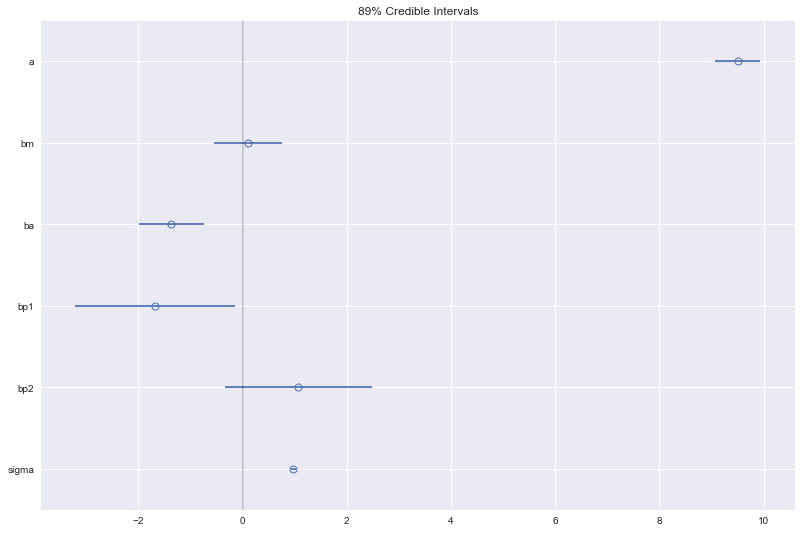

In [68]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5m4, varnames=["a", "bm", "ba", "bp1", "bp2", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=6, alpha=0.2);
ax.set_ylim(-0.5, 5.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

#### 5M5.

I'm assuming we have average calories gained by eating outside (co) and average calories burned through exercise (ce) and we're fitting a model to the obesity rate per region pulled from $\mathcal{N}(\mu, \sigma)$

If we fit $\mu_i = \alpha + \beta_g g_i + \beta_{co} co_i + \beta_{ce} ce_i$ There are a few possibilities for the coefficients.

1. $\beta_g$ still has an effect on our predictions - this implies that our model is incorrect.
2. Either $\beta_{co}$ or $\beta_{ce}$ covers 0, this implies that our model is correct and the significant coefficient is consequence of the higher gas prices.
3. Both $\beta_{co}$ and $\beta_{ce}$ are significant - this implies that both phenomena occur and the significance can give you an estimate of how much each one contribues.

These are all contingent on our model being correct.